### **Assignment #3**

In this assignment, you will learn about regularization methods. You will also implement the ridge regularization method using gradient descent and stochastic gradient
descent and test it on "Wine quality" data.
Be careful not to use the same data for training (any stage of training) and testing your
model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score


Use the "Communities and Crime" dataset you used in the previous assignment with
the same preprocessing.

The last column of the dataset (ViolentCrimesPerPop) is your target variable. Remove
the attributes state, county, community, community name, and fold (columns 1 to 5).
https://archive.ics.uci.edu/dataset/183/communities+and+crime

In [2]:
# scrap feature names from 'communities.names'
attr_names = []
with open('communities.names') as f:
    for row in f:
        if row[:len('@attribute')] == '@attribute':
            attr_names.append(row.split(" ")[1])
len(attr_names)

128

In [3]:
# load data and add feature names
data = pd.read_csv('communities.data', delimiter=',', header=None, names=attr_names)
# remove the first 5 features as per instructions
data = data.drop(data[['state', 'county', 'community', 'communityname', 'fold']], axis=1)
# remove all features with a lot of missing data ('?')
data = data.drop(data[[i for i in data if sum([1 if e == '?' else 0 for e in data.loc[:, i]]) > 10]], axis=1)
# remove a single sample where data is still missing
data = data.drop(130)
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [4]:
# randomize samples
data = data.sample(frac=1).reset_index(drop=True)
# split data
X = data[data.columns[range(100)]]
Y = data[data.columns[[100]]]
n = len(data)
x_train = X[:int(n * 0.7)]
x_test = X[int(n * 0.7):]
y_train = Y[:int(n * 0.7)]
y_test = Y[int(n * 0.7):]

Fit models using ridge and lasso regression. Try different values of the regularization
parameter and evaluate its effect. Choose the optimal regularization parameter. Use the Scikit-learn functions for ridge, lasso, and for the selection of the regularization
parameter.

In [5]:
lasso = LassoCV(cv=5).fit(x_train, y_train['ViolentCrimesPerPop'])
pred_lass = lasso.predict(x_test)
r2_score(y_test['ViolentCrimesPerPop'], pred_lass), lasso.alpha_

(0.6457374076421771, 0.00011693643946646515)

In [6]:
ridge = RidgeCV(cv=5).fit(x_train, y_train['ViolentCrimesPerPop'])
pred_ridge = ridge.predict(x_test)
r2_score(y_test['ViolentCrimesPerPop'], pred_ridge), ridge.alpha_

(0.6464393811990135, 1.0)

In [7]:
def k_fold(k, X):
    # X and Y have to be of the same length obviously
    n = len(X)

    f_size = n//k

    index_list = [] # n=10, k=5, return: [(2:, :2), (:2 + 4:, 2:4), (:4 + 6:, 4:6), (:6 + 8:, 6:8), (:8, 8:)], where (train, test)

    for i in range(k):
        index_list.append(
            (list(range(0, i*f_size)) + list(range((i+1)*f_size, n)),
             list(range(i*f_size, (i+1)*f_size)))
        )

    return index_list

def fw_feature_selection(x, y, k):
    last_mse = 1000
    selection = []
    past_mses = []
    
    while True:
        scores = [] 
        for attr in x.columns:
            if attr not in selection:
                sum_mse = 0
                for train, test in k_fold(k, x):
                    lr = LinearRegression().fit(x.loc[train][selection + [attr]], y.loc[train])
                    pred = lr.predict(x.loc[test][selection + [attr]])
                    sum_mse += mean_squared_error(y.loc[test], pred)
                
                scores.append((sum_mse/k, attr))

        current_mse, min_attr = min(scores)

        if current_mse >= last_mse:
            break
        else:
            last_mse = current_mse
            past_mses += [current_mse]
            selection += [min_attr]
        
        if len(selection) == len(x.columns): # to avoid potential inf loop
            break

    return selection, past_mses

In [8]:
selected, mses = fw_feature_selection(x_train, y_train, 5)

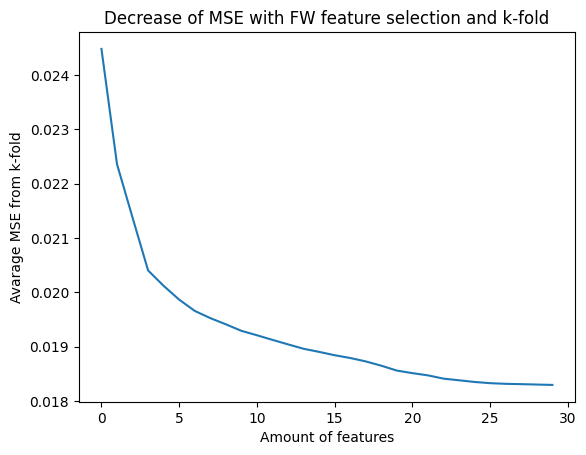

In [9]:
plt.plot(range(len(mses)), mses)
plt.xlabel('Amount of features')
plt.ylabel('Avarage MSE from k-fold')
plt.title('Decrease of MSE with FW feature selection and k-fold')
plt.show()

Compare the results of the feature selection you implemented in the previous assignment with the attributes lasso selected.

In [10]:
tmp = LassoCV(cv=5).fit(x_train, y_train['ViolentCrimesPerPop'])
#predicted = tmp.predict(x_test)
koef = tmp.coef_
tmpl = []
for i, k in enumerate(koef):
    if k != 0:
        tmpl.append((abs(k), attr_names[i])) # abs ker isces relevanco, ce je sorazmerna al pa obratno sorazmerna nima veze
lasso_selected = sorted(tmpl, reverse=True) # sorted, najbolj relevantni na začetku

In [11]:
match = [name for e, name in lasso_selected if name in selected]
print(f"Selected by my forward feature select: {len(selected)}\nSelected by Lasso: {len(lasso_selected)}\nThe amount of features that match: {len(match)}")

Selected by my forward feature select: 30
Selected by Lasso: 66
The amount of features that match: 15


Download the "Wine quality" dataset. Choose only the white wine data. Prepare
your data for modeling. The data is available at https://archive.ics.uci.edu/dataset/186/wine+quality.
You will be doing a regression of the wine quality grades (last column).

In [12]:
data_wine = pd.read_csv('winequality-white.csv', delimiter=';')
data_wine['intercept'] = 1
data_wine = data_wine[['intercept'] + data_wine.columns.to_list()[:12]]
citric = data_wine['citric acid']
data_wine.head()

,intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [13]:
for feat in data_wine.columns.to_list()[1:]:
    feat_data = data_wine[feat]
    data_wine[feat] = (feat_data - np.mean(feat_data))/np.std(feat_data)

data_wine.head()

,intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152,0.13787
1,1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276,0.13787
2,1,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667,0.13787
3,1,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,0.13787
4,1,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,0.13787


In [14]:
# shuffle data
data_wine = data_wine.sample(frac=1).reset_index(drop=True)
# split data
n = len(data_wine)
wine_train = data_wine.loc[:int(n * 0.7)]
wine_test = data_wine.loc[int(n * 0.7):]

w_x_train = wine_train.drop(wine_train[['quality']], axis=1)
w_y_train = wine_train['quality']

w_x_test = wine_test.drop(wine_test[['quality']], axis=1)
w_y_test = wine_test['quality']

In [15]:
lr = LinearRegression().fit(w_x_train, w_y_train)
pred = lr.predict(w_x_test)
mse = mean_squared_error(w_y_test, pred)
r2 = r2_score(w_y_test, pred)
print(f"MSE: {mse}, R2: {r2}")

MSE: 0.7572281522899893, R2: 0.26743085032506997


Implement ridge regression with:
- gradient descent
- stochastic gradient descent

and test it on the "Wine quality" data. It is expected that the gradient descent is implemented from scratch. You can check
out these [slides](https://courses.cs.washington.edu/courses/cse446/17wi/slides/ridgeregression-annotated.pdf).

In [16]:
def ridge_regression(x, y, beta, alpha, num_of_iter=1000, l_rate=0.3, stoh=False):

    loss_hist = []

    for _ in range(num_of_iter):
        if not stoh:
            pred = x @ beta
            err = y - pred
            ridge_loss = err.T @ err + alpha*(beta.T @ beta)
            loss_hist.append(ridge_loss)
            gradient = -2/len(x) * (x.T @ err) + alpha*beta
            beta = beta - l_rate * gradient
        else:
            indices = np.arange(0, len(x))
            np.random.shuffle(indices)
            for i in indices:
                pred = x @ beta
                err = y - pred
                ridge_loss = err.T @ err + alpha*(beta.T @ beta)
                loss_hist.append(ridge_loss)

                gradient = -2/len(x) * (x.loc[i] * (y.loc[i] - (x.loc[i] @ beta))) + alpha*beta
                beta = beta - l_rate * gradient
                #print(gradient)

        if len(loss_hist) > 5: # stop if loss starts getting worse 
            if abs(loss_hist[-5] - ridge_loss) < 0.01:
                break
        
    return beta, loss_hist


Test different learning rates and try to find the optimal one. Compare the time to convergence and the results of the two gradient descents you
implemented.

R2: 0.2712003103287156; Iteration: 355
R2: 0.27496213231700717; Iteration: 3901
R2: 0.2715186306030193; Iteration: 8650


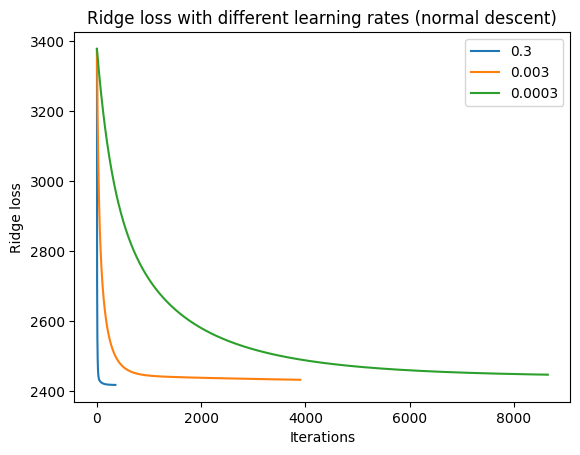

In [21]:
learning_rates = [0.3, 0.003, 0.0003]
for l_rate in learning_rates:
    beta = np.array([0]*12)
    beta, loss_h = ridge_regression(w_x_train, w_y_train, beta, 0.005, 10000, l_rate, stoh=False)
    plt.plot(loss_h)
    print(f"R2: {r2_score(w_y_test, w_x_test @ beta)}; Iteration: {len(loss_h)}")
plt.title("Ridge loss with different learning rates (normal descent)")
plt.xlabel("Iterations")
plt.ylabel("Ridge loss")
plt.legend(learning_rates)
plt.show()

R2: 0.16476949109085726, Iteration: 7.0 (x 3429)


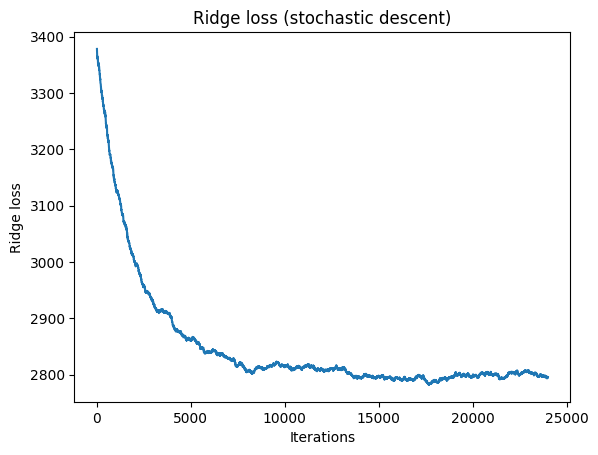

In [27]:
beta = np.array([0]*12)
beta, loss_h = ridge_regression(w_x_train, w_y_train, beta, 0.001, 7, 0.2, stoh=True)
print(f"R2: {r2_score(w_y_test, w_x_test @ beta)}, Iteration: {len(loss_h)/len(w_x_train)} (x {len(w_x_train)})")
plt.plot(loss_h)
plt.title("Ridge loss (stochastic descent)")
plt.xlabel("Iterations")
plt.ylabel("Ridge loss")
plt.show()